In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
import re
import string
import zlib
import numpy as np
import emoji

from collections import Counter
from scipy.stats import entropy

from nltk import sent_tokenize, word_tokenize, pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
from textblob import TextBlob

analyzer = SentimentIntensityAnalyzer()

DIGIT_PATTERN = r"\d"
SPECIAL_CHAR_PATTERN = r"[^A-Za-z0-9 ]"
USER_PATTERN = r"(?<!\w)@[A-Za-z0-9_]{1,15}\b"
URL_PATTERN = r"(https?://[^\s]+|www\.[^\s]+)"
HASHTAG_PATTERN = r"#\w+"
CASHTAG_PATTERN = r"\$\w+"
EMAIL_PATTERN = r"\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b"

FUNCTION_WORDS = {
  "the", "a", "an", "and", "or", "but", "if", "while", "with", "to", "of", "in", "on",
  "for", "from", "by", "is", "are", "was", "were", "be", "been", "being"
}

def normalize_entities(text):
  if not isinstance(text, str) or text.strip() == "":
    return text
  
  text = re.sub(EMAIL_PATTERN, "<EMAIL>", text)
  text = re.sub(URL_PATTERN, "<URL>", text)
  text = re.sub(USER_PATTERN, "<USER>", text)

  return text

def extract_text_features(text, is_tweet=False):
  if not isinstance(text, str) or text.strip() == "":
    return {
        "is_present": False,
        "length": None,
        "num_words": None,
        "num_sentences": None,
        "avg_sentence_length": None,
        "avg_word_length": None,
        "std_word_length": None,
        "unique_word_ratio": None,
        "guiraud_index": None,
        "repetition_ratio": None,
        "hapax_ratio": None,
        "digit_ratio": None,
        "uppercase_ratio": None,
        "lowercase_ratio": None,
        "special_char_ratio": None,
        "punctuation_ratio": None,
        "whitespace_ratio": None,
        "emoji_count": None,
        "emoji_ratio": None,
        "mention_count": None,
        "contains_mention": False,
        "url_count": None,
        "contains_url": False,
        "hashtag_count": None,
        "cashtag_count": None,
        "email_count": None,
        "contains_bot_word_or_hashtag": False,
        "contains_ai_hashtag": False,
        "sentiment": None,
        "sentiment_abs": None,
        "sentiment_neutrality": None,
        "sentiment_subjectivity": None,
        "flesch_reading_ease": None,
        "flesch_kincaid_grade": None,
        "avg_syllables_per_word": None,
        "polysyllabic_word_ratio": None,
        "char_entropy": None,
        "word_entropy": None,
        "compression_ratio": None,
        "starts_with_emoji": False,
        "ends_with_emoji": False,
        "starts_with_url": False,
        "ends_with_url": False,
        "contains_pipe_or_bullet": False,
        "contains_call_to_action": False,
        "contains_ai_phrase": False,
        "function_word_ratio": None,
        "noun_ratio": None,
        "verb_ratio": None,
        "pronoun_ratio": None,
        "adjective_ratio": None,
        "contains_repeated_chars": False,
        "is_retweet": False,
        "is_quote": False
    }

  text = text.strip()
  text = normalize_entities(text)
  char_len = len(text)

  words = word_tokenize(text)
  words_lower = [w.lower() for w in words if w.isalpha()]
  num_words = len(words_lower)

  sentences = sent_tokenize(text)
  num_sentences = len(sentences)

  # --- A: Presence & length
  avg_sentence_length = num_words / num_sentences if num_sentences else None

  # --- B: Lexical structure
  word_lengths = [len(w) for w in words_lower]
  avg_word_length = np.mean(word_lengths) if word_lengths else None
  std_word_length = np.std(word_lengths) if word_lengths else None

  word_counts = Counter(words_lower)
  unique_word_ratio = len(word_counts) / num_words if num_words else None
  guiraud_index = len(word_counts) / np.sqrt(num_words) if num_words else None
  repetition_ratio = 1 - unique_word_ratio if unique_word_ratio is not None else None
  hapax_ratio = sum(1 for w in word_counts if word_counts[w] == 1) / num_words if num_words else None

  # --- C: Character composition
  digits = len(re.findall(DIGIT_PATTERN, text))
  letters = re.findall(r"[A-Za-z]", text)
  uppercase = sum(1 for c in letters if c.isupper())
  lowercase = sum(1 for c in letters if c.islower())
  special_chars = len(re.findall(SPECIAL_CHAR_PATTERN, text))
  punctuation = sum(1 for c in text if c in string.punctuation)
  whitespaces = text.count(" ")

  emoji_count = sum(1 for c in text if c in emoji.EMOJI_DATA)

  digit_ratio = digits / char_len
  uppercase_ratio = uppercase / len(letters) if letters else None
  lowercase_ratio = lowercase / len(letters) if letters else None
  special_char_ratio = special_chars / char_len
  punctuation_ratio = punctuation / char_len
  whitespace_ratio = whitespaces / char_len
  emoji_ratio = emoji_count / char_len

  # --- D: Token usage
  mention_count = text.count("<USER>")
  url_count = text.count("<URL>")
  hashtag_count = len(re.findall(HASHTAG_PATTERN, text))
  cashtag_count = len(re.findall(CASHTAG_PATTERN, text))
  email_count = text.count("<EMAIL>")

  # --- E: Semantic signals
  contains_bot_word_or_hashtag = bool(re.search(r"(?i)(\bbot\b|#\w*bot\b)", text))
  contains_ai_hashtag = bool(re.search(r"(?i)\b#ai\b|#\w+ai\b", text))

  sentiment = analyzer.polarity_scores(text)["compound"]
  sentiment_abs = abs(sentiment)
  sentiment_neutrality = 1 - sentiment_abs
  
  blob = TextBlob(text)
  sentiment_subjectivity = blob.sentiment.subjectivity

  # --- F: Readability
  flesch_reading_ease = textstat.flesch_reading_ease(text)
  flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
  avg_syllables_per_word = textstat.avg_syllables_per_word(text)
  polysyllabic_word_ratio = textstat.polysyllabcount(text) / num_words if num_words else None

  # --- G: Entropy & compression
  char_entropy = entropy(list(Counter(text).values()), base=2)
  word_entropy = entropy(list(word_counts.values()), base=2) if word_counts else None
  avg_word_repetition = np.mean(list(word_counts.values())) if word_counts else None
  compression_ratio = len(zlib.compress(text.encode("utf-8"))) / char_len

  # --- H: Template indicators
  starts_with_emoji = text[0] in emoji.EMOJI_DATA
  ends_with_emoji = text[-1] in emoji.EMOJI_DATA
  starts_with_url = text.startswith("<URL>")
  ends_with_url = text.endswith("<URL>")
  contains_pipe_or_bullet = bool(re.search(r"\s[|•]\s", text))
  contains_call_to_action = bool(re.search(r"(?i)\b(follow|dm|click|join|subscribe|contact|call|buy|giveaway|free|win|retweet|apply)\b", text))
  contains_ai_phrase = bool(re.search(r"(?i)\b(powered by AI|autogenerated|generated by AI|AI assistant)\b", text))

  # --- I: Grammatical composition (self-reference & POS)
  function_word_ratio = sum(w in FUNCTION_WORDS for w in words_lower) / num_words if num_words else None

  pos_tags = pos_tag(words_lower)
  pos_counts = Counter(tag for _, tag in pos_tags)

  noun_ratio = sum(pos_counts[t] for t in ["NN", "NNS", "NNP", "NNPS"]) / num_words if num_words else None
  verb_ratio = sum(pos_counts[t] for t in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]) / num_words if num_words else None
  pronoun_ratio = sum(pos_counts[t] for t in ["PRP", "PRP$"]) / num_words if num_words else None
  adjective_ratio = sum(pos_counts[t] for t in ["JJ", "JJR", "JJS"]) / num_words if num_words else None
 
  # --- J: Noise & stylistic irregularities
  contains_repeated_chars = bool(re.search(r'(.)\1{2,}', text))

  # --- K: Platform-specific discourse markers (tweets only)
  if is_tweet:
    is_retweet = bool(re.match(r'^RT\s+<USER>', text))
    is_quote = bool(re.match(r'^(QT|“|")', text))
  else:
    is_retweet = None
    is_quote = None

  return {
      "is_present": True,
      "length": char_len,
      "num_words": num_words,
      "num_sentences": num_sentences,
      "avg_sentence_length": avg_sentence_length,
      "avg_word_length": avg_word_length,
      "std_word_length": std_word_length,
      "unique_word_ratio": unique_word_ratio,
      "guiraud_index": guiraud_index,
      "repetition_ratio": repetition_ratio,
      "hapax_ratio": hapax_ratio,
      "digit_ratio": digit_ratio,
      "uppercase_ratio": uppercase_ratio,
      "lowercase_ratio": lowercase_ratio,
      "special_char_ratio": special_char_ratio,
      "punctuation_ratio": punctuation_ratio,
      "whitespace_ratio": whitespace_ratio,
      "emoji_count": emoji_count,
      "emoji_ratio": emoji_ratio,
      "mention_count": mention_count,
      "contains_mention": mention_count > 0,
      "url_count": url_count,
      "contains_url": url_count > 0,
      "hashtag_count": hashtag_count,
      "cashtag_count": cashtag_count,
      "email_count": email_count,
      "contains_bot_word_or_hashtag": contains_bot_word_or_hashtag,
      "contains_ai_hashtag": contains_ai_hashtag,
      "sentiment": sentiment,
      "sentiment_abs": sentiment_abs,
      "sentiment_neutrality": sentiment_neutrality,
      "sentiment_subjectivity": sentiment_subjectivity,
      "flesch_reading_ease": flesch_reading_ease,
      "flesch_kincaid_grade": flesch_kincaid_grade,
      "avg_syllables_per_word": avg_syllables_per_word,
      "polysyllabic_word_ratio": polysyllabic_word_ratio,
      "char_entropy": char_entropy,
      "word_entropy": word_entropy,
      "avg_word_repetition": avg_word_repetition,
      "compression_ratio": compression_ratio,
      "starts_with_emoji": starts_with_emoji,
      "ends_with_emoji": ends_with_emoji,
      "starts_with_url": starts_with_url,
      "ends_with_url": ends_with_url,
      "contains_pipe_or_bullet": contains_pipe_or_bullet,
      "contains_call_to_action": contains_call_to_action,
      "contains_ai_phrase": contains_ai_phrase,
      "function_word_ratio": function_word_ratio,
      "noun_ratio": noun_ratio,
      "verb_ratio": verb_ratio,
      "pronoun_ratio": pronoun_ratio,
      "adjective_ratio": adjective_ratio,
      "contains_repeated_chars": contains_repeated_chars,
      "is_retweet": is_retweet,
      "is_quote": is_quote
  }

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def plot_numeric(df, feature, label_col="label"):
    weights = df.groupby(label_col)[feature].transform(lambda x: 1 / len(x))

    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=df,
        x=feature,
        hue=label_col,
        bins=50,
        weights=weights,
        alpha=0.6
    )
    plt.title(f"{feature} by {label_col} (normalized)")
    plt.ylabel("Relative frequency")
    plt.show()


def plot_boolean(df, feature, label_col="label"):
    prop_df = (
        df
        .groupby(label_col)[feature]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=prop_df,
        x=feature,
        y="proportion",
        hue=label_col
    )
    plt.title(f"{feature} by {label_col}")
    plt.ylabel("Proportion")
    plt.show()

In [5]:
user_features = pd.read_parquet(f"../../02_data/user_features.parquet", engine='pyarrow')
user_features.head(2)

,id,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label
0,u1000115670657318912,4,6,1.500000,"Open source tool for data & models versioning for ML projects. Join our stellar community https://t.co/vBp8rcV4bf for help, support and insights.",145,True,True,True,False,True,True,False,False,0.0,0.0,0.013793,0.25,0.0,0.062069,3.000000,1.000000,2.000000,2.584963,0.666667,0.765,0,0,0,1,False,False,241456966,3488,325,79,911,10.732308,21.464615,0.093177,0.000027,0.085235,0.022649,0.261181,0.086718,0.000014,0.000001,3.271805e-07,0.000004,human
1,u1000483839800627200,12,11,0.916667,"Theoretical biologist and advisor to data scientists. I have published in evolution, biochemistry, infectious disease, economics, education. Opinions my own.",157,True,True,True,True,True,True,False,False,0.0,0.0,0.000000,0.00,0.0,0.044586,0.222222,0.222222,3.022055,2.845351,0.083333,0.000,0,0,0,0,False,False,241369187,2563,458,60,2002,5.596070,11.192140,0.178697,0.000070,0.151605,0.023410,0.781116,0.029970,0.000011,0.000002,2.485819e-07,0.000008,human


In [6]:
n_rows, n_columns = user_features.shape
print(f"The dataset contains {n_rows} rows and {n_columns} columns.")

The dataset contains 99967 rows and 50 columns.


In [7]:
columns_to_drop = ["description_length", "has_description",
                   "has_bot_word_in_description", "ratio_digits_in_description",
                   "ratio_special_chars_in_description", "description_sentiment",
                   "cashtag_in_description_count", "hashtag_in_description_count",
                   "mention_in_description_count", "url_in_description_count"]

user_features = user_features.drop(columns=columns_to_drop)

user_features['label'] = user_features['label'].map({'human': 0, 'bot': 1})

In [ ]:
desc_feature_df = user_features["description"].apply(extract_text_features).apply(pd.Series)
desc_feature_df.rename(columns={c: f"desc_{c}" for c in desc_feature_df.columns}, inplace=True)

user_features_1 = pd.concat([user_features, desc_feature_df], axis=1)
user_features_1.head(2)

In [ ]:
import joblib

joblib.dump(user_features_1, f"../../02_data/user_features_1.joblib")

['../../02_data/user_features_1.joblib']

In [ ]:
tweet_features = pd.read_parquet(f"../../02_data/tweet_features.parquet", engine='pyarrow')
tweet_features.head(2)

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label
0,u1001495628738957312,t1502310945158275074,"Join us for a special screening of the documentary #SAPELO and a Q&amp;A with the filmmakers on Thursday, March 31 at the @CarterCenter!📽️🇨🇭 @CarterLibrary @SWISS_FILMS https://t.co/53nsRtRI8u",2022-03-11 15:50:15+00:00,0,0,1,0.0,0.0,1,human
1,u1002590470097154048,t1459274835377500161,Looking forward to meeting the final chapter👀👀 https://t.co/6NsqPBe272,2021-11-12 21:40:07+00:00,0,0,0,NaN,NaN,0,bot
2,u1002590470097154048,t1405835036847443969,"RT @HamidrezaKasaei: Our new service robot is getting ready to be used in amazing researches on ""generalizable perception and manipulation…",2021-06-18 10:29:26+00:00,0,0,0,NaN,NaN,1,bot
3,u1002590470097154048,t1401642372044296199,"RT @yao_weijia: I'm happy to be a finalist for the ICRA Best Paper Award &amp; grateful to coauthors @HectorGdeMarina, Zhiyong, @MingCao10. I t…",2021-06-06 20:49:17+00:00,0,0,0,NaN,NaN,3,bot
4,u1002590470097154048,t1379337484384014336,"RT @corl_conf: The Conference on #Robot #Learning 2021 will be held on Nov 8-11 in London, UK &amp; virtually. Exciting new changes, including:…",2021-04-06 07:37:37+00:00,0,0,0,NaN,NaN,44,bot
5,u1002590470097154048,t1375413282966753290,@yao_weijia @HectorGdeMarina @zhiyong @MingCao10 Congratulations Weijia🎉,2021-03-26 11:44:15+00:00,1,0,1,NaN,NaN,0,bot
6,u1002590470097154048,t1375413169594699778,"RT @yao_weijia: A guiding vector field is typically used for the guidance of a single vehicle. I, with @HectorGdeMarina, @Zhiyong, @MingCao…",2021-03-26 11:43:48+00:00,0,0,0,NaN,NaN,3,bot
7,u1002590470097154048,t1346466348134633477,RT @MingCao10: Our @yao_weijia @HectorGdeMarina new #robot navigation #algorithm uses singularity-free guiding vector fields https://t.co/…,2021-01-05 14:39:28+00:00,0,0,0,NaN,NaN,4,bot
8,u1002590470097154048,t1278585165229547520,RT @svlevine: The papers I covered:\nD4RL (benchmarks): https://t.co/MvBXpRYGte\nCQL (lower bound algorithm): https://t.co/TYL7RTvAWz\nAWAC (s…,2020-07-02 07:03:53+00:00,0,0,0,NaN,NaN,10,bot
9,u1002590470097154048,t1278585146254467073,"RT @svlevine: Offline reinforcement learning talk, which I prepared for a seminar at Google -- here is a recording I made (while rehearsing…",2020-07-02 07:03:48+00:00,0,0,0,NaN,NaN,61,bot


In [ ]:
n_rows, n_columns = tweet_features.shape
print(f"The dataset contains {n_rows} rows and {n_columns} columns.")

The dataset contains 1048873 rows and 11 columns.


In [ ]:
tweet_features['label'] = tweet_features['label'].map({'human': 0, 'bot': 1})

In [ ]:
tweet_feature_df = tweet_features["text"].apply(lambda x: extract_text_features(x, is_tweet=True)).apply(pd.Series)
tweet_feature_df.rename(columns={c: f"tweet_{c}" for c in tweet_feature_df.columns}, inplace=True)

tweet_features_1 = pd.concat([tweet_features, tweet_feature_df], axis=1)
tweet_features_1.head()

In [ ]:
import joblib

joblib.dump(tweet_features_1, f"../../02_data/tweet_features_1.joblib")

In [10]:
tweet_features['quote_count_missing'] = tweet_features['quote_count'].isnull().astype(bool)
tweet_features['reply_count_missing'] = tweet_features['reply_count'].isnull().astype(bool)

In [11]:
tweet_features.dtypes

,0
author_id,object
id,object
text,object
created_at,object
is_reply,int32
is_sensitive,int32
like_count,int64
quote_count,float64
reply_count,float64
retweet_count,int64


In [12]:
tweet_features["is_reply"] = tweet_features["is_reply"].astype(bool)
tweet_features["is_sensitive"] = tweet_features["is_sensitive"].astype(bool)

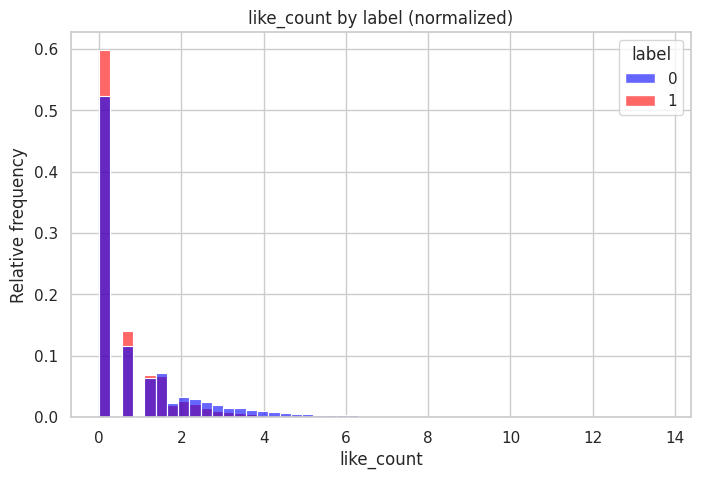

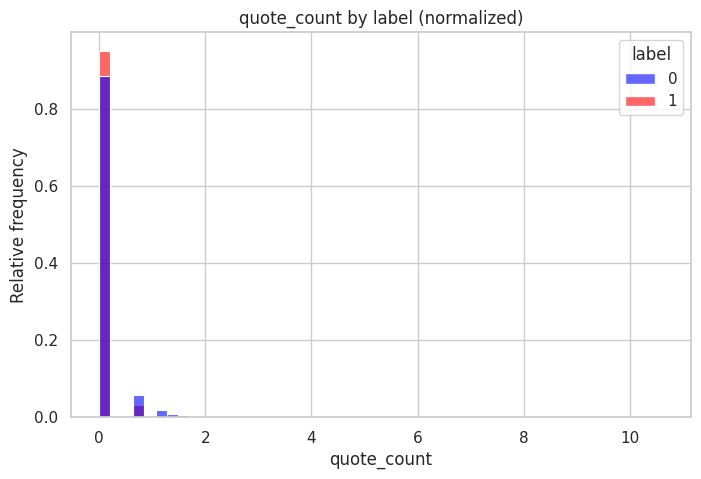

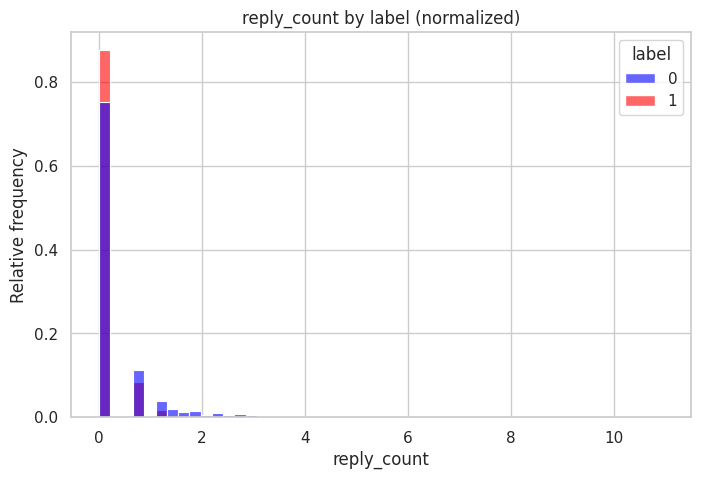

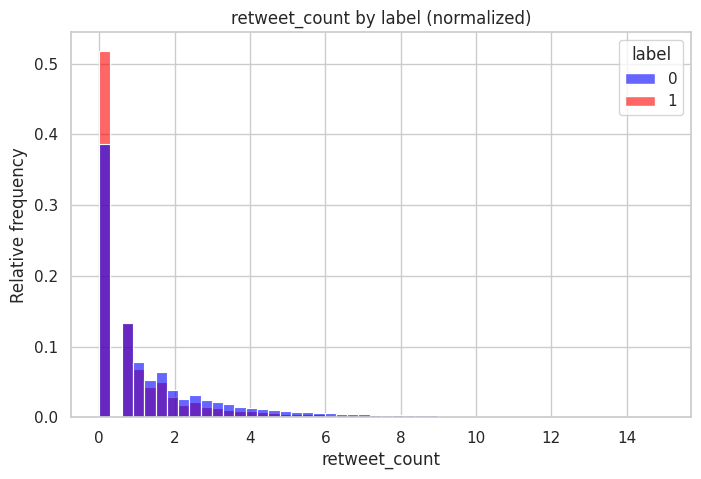

In [13]:
numeric_cols = [col for col in tweet_features.select_dtypes(include=np.number).columns if col != "label"]

for col in numeric_cols:
  df_plot = tweet_features[[col, 'label']].dropna(subset=[col])
  plot_numeric(df_plot, col)

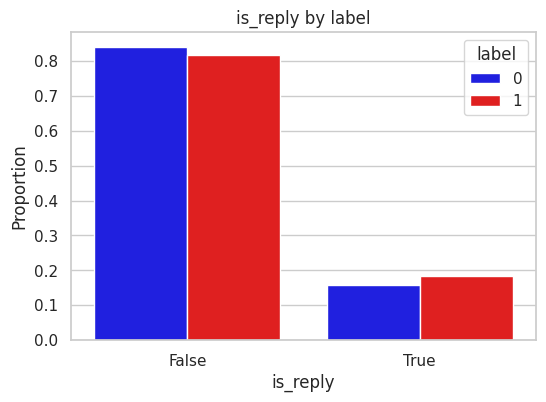

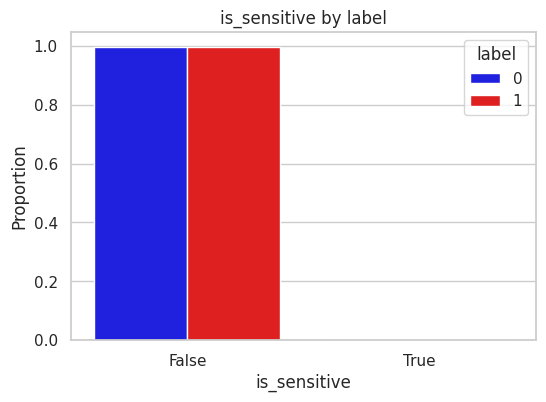

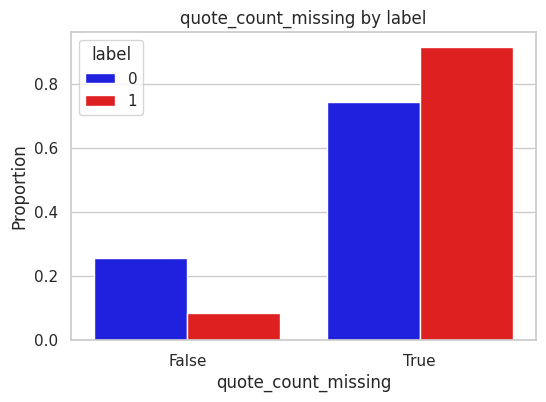

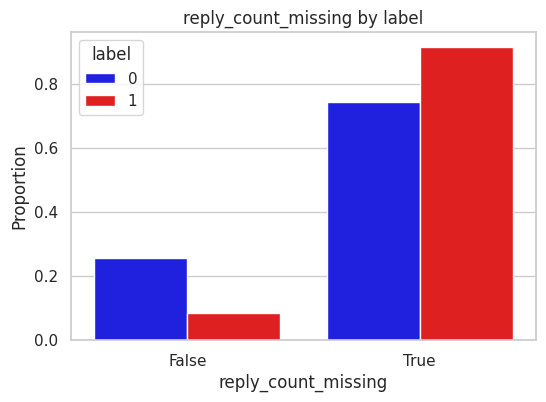

In [14]:
bool_cols = tweet_features.select_dtypes(include=['bool']).columns

for col in bool_cols:
  plot_boolean(tweet_features, col)

In [15]:
for col in ['quote_count', 'reply_count']:
  tweet_features[col] = tweet_features[col].fillna(0)

In [16]:
# Check for missing values
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [17]:
tweet_features.head(20)

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label,quote_count_missing,reply_count_missing
0,u1001495628738957312,t1502310945158275074,"Join us for a special screening of the documentary #SAPELO and a Q&amp;A with the filmmakers on Thursday, March 31 at the <USER>!📽️🇨🇭 <USER> <USER> <URL>",2022-03-11 15:50:15+00:00,False,False,1,0.000000,0.000000,1,0,False,False
1,u1002590470097154048,t1459274835377500161,Looking forward to meeting the final chapter👀👀 <URL>,2021-11-12 21:40:07+00:00,False,False,0,0.000000,0.000000,0,1,True,True
2,u1002590470097154048,t1405835036847443969,"RT <USER>: Our new service robot is getting ready to be used in amazing researches on ""generalizable perception and manipulation…",2021-06-18 10:29:26+00:00,False,False,0,0.000000,0.000000,1,1,True,True
3,u1002590470097154048,t1401642372044296199,"RT <USER>: I'm happy to be a finalist for the ICRA Best Paper Award &amp; grateful to coauthors <USER>, Zhiyong, <USER>. I t…",2021-06-06 20:49:17+00:00,False,False,0,0.000000,0.000000,3,1,True,True
4,u1002590470097154048,t1379337484384014336,"RT <USER>: The Conference on #Robot #Learning 2021 will be held on Nov 8-11 in London, UK &amp; virtually. Exciting new changes, including:…",2021-04-06 07:37:37+00:00,False,False,0,0.000000,0.000000,44,1,True,True
5,u1002590470097154048,t1375413282966753290,<USER> <USER> <USER> <USER> Congratulations Weijia🎉,2021-03-26 11:44:15+00:00,True,False,1,0.000000,0.000000,0,1,True,True
6,u1002590470097154048,t1375413169594699778,"RT <USER>: A guiding vector field is typically used for the guidance of a single vehicle. I, with <USER>, <USER>, <USER>…",2021-03-26 11:43:48+00:00,False,False,0,0.000000,0.000000,3,1,True,True
7,u1002590470097154048,t1346466348134633477,RT <USER>: Our <USER> <USER> new #robot navigation #algorithm uses singularity-free guiding vector fields <URL>,2021-01-05 14:39:28+00:00,False,False,0,0.000000,0.000000,4,1,True,True
8,u1002590470097154048,t1278585165229547520,RT <USER>: The papers I covered:\nD4RL (benchmarks): <URL>\nCQL (lower bound algorithm): <URL>\nAWAC (s…,2020-07-02 07:03:53+00:00,False,False,0,0.000000,0.000000,10,1,True,True
9,u1002590470097154048,t1278585146254467073,"RT <USER>: Offline reinforcement learning talk, which I prepared for a seminar at Google -- here is a recording I made (while rehearsing…",2020-07-02 07:03:48+00:00,False,False,0,0.000000,0.000000,61,1,True,True


In [18]:
!pip install emoji langdetect vaderSentiment textstat

In [19]:
import nltk
nltk.download("punkt_tab")
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [29]:
import re
import math
import string
import zlib
import numpy as np
import pandas as pd
import emoji
from collections import Counter
from scipy.stats import entropy
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
from textblob import TextBlob

analyzer = SentimentIntensityAnalyzer()

URL_PATTERN = r"<URL>"
USER_PATTERN = r"<USER>"
EMAIL_PATTERN = r"<EMAIL>"
HASHTAG_PATTERN = r"#\w+"
CASHTAG_PATTERN = r"\$\w+"
DIGIT_PATTERN = r"\d"
SPECIAL_CHAR_PATTERN = r"[^A-Za-z0-9 ]"

def extract_tweet_features(text):

  if not isinstance(text, str) or text.strip() == "":
    return {
        "has_tweet": False,
        "tweet_length": None,
        "num_words": None,
        "avg_word_length": None,
        "std_word_length": None,
        "unique_word_ratio": None,
        "repetition_ratio": None,
        "hapax_ratio": None,
        "digit_ratio": None,
        "uppercase_ratio": None,
        "lowercase_ratio": None,
        "special_char_ratio": None,
        "punctuation_ratio": None,
        "whitespace_ratio": None,
        "emoji_count": None,
        "emoji_ratio": None,
        "mention_count": None,
        "has_mention": False,
        "url_count": None,
        "has_url": False,
        "hashtag_count": None,
        "cashtag_count": None,
        "email_count": None,
        "sentiment_polarity": None,
        "sentiment_abs": None,
        "sentiment_neutrality": None,
        "sentiment_subjectivity": None,
        "flesch_reading_ease": None,
        "flesch_kincaid_grade": None,
        "avg_syllables_per_word": None,
        "polysyllabic_word_ratio": None,
        "char_entropy": None,
        "word_entropy": None,
        "compression_ratio": None,
        "noun_ratio": None,
        "verb_ratio": None,
        "pronoun_ratio": None,
        "adjective_ratio": None,
        "num_slangs": None,
        "has_repeated_chars": False,
        "is_all_caps": False,
        "first_person_ratio": None,
        "third_person_ratio": None,
        "contains_keyword": False,
        "is_retweet": False,
        "is_quote": False,
        "has_media": False,
        "has_poll": False,
        "num_exclamations": None,
        "num_questions": None,
        "num_dots": None,
        "num_commas": None
        }

  text = text.strip()
  char_len = len(text)

  words = word_tokenize(text)
  words_lower = [w.lower() for w in words if w.isalpha()]
  num_words = len(words_lower)

  word_lengths = [len(w) for w in words_lower]
  avg_word_length = np.mean(word_lengths) if word_lengths else None
  std_word_length = np.std(word_lengths) if word_lengths else None

  word_counts = Counter(words_lower)
  unique_word_ratio = len(word_counts) / num_words if num_words else None
  repetition_ratio = 1 - unique_word_ratio if unique_word_ratio is not None else None
  hapax_ratio = sum(1 for w in word_counts if word_counts[w] == 1) / num_words if num_words else None

  digits = len(re.findall(DIGIT_PATTERN, text))
  letters = re.findall(r"[A-Za-z]", text)
  uppercase = sum(1 for c in letters if c.isupper())
  lowercase = sum(1 for c in letters if c.islower())
  special_chars = len(re.findall(SPECIAL_CHAR_PATTERN, text))
  punctuation = sum(1 for c in text if c in string.punctuation)
  whitespaces = text.count(" ")

  emoji_count = sum(1 for c in text if c in emoji.EMOJI_DATA)

  digit_ratio = digits / char_len
  uppercase_ratio = uppercase / len(letters) if letters else None
  lowercase_ratio = lowercase / len(letters) if letters else None
  special_char_ratio = special_chars / char_len
  punctuation_ratio = punctuation / char_len
  whitespace_ratio = whitespaces / char_len
  emoji_ratio = emoji_count / char_len

  mention_count = len(re.findall(USER_PATTERN, text))
  url_count = len(re.findall(URL_PATTERN, text))
  hashtag_count = len(re.findall(HASHTAG_PATTERN, text))
  cashtag_count = len(re.findall(CASHTAG_PATTERN, text))
  email_count = len(re.findall(EMAIL_PATTERN, text))

  sentiment = analyzer.polarity_scores(text)["compound"]
  sentiment_abs = abs(sentiment)
  sentiment_neutrality = 1 - sentiment_abs

  blob = TextBlob(text)
  sentiment_subjectivity = blob.sentiment.subjectivity

  flesch_reading_ease = textstat.flesch_reading_ease(text)
  flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
  avg_syllables_per_word = textstat.avg_syllables_per_word(text)
  polysyllabic_word_ratio = textstat.polysyllabcount(text) / num_words if num_words else None

  char_entropy = entropy(list(Counter(text).values()), base=2)
  word_entropy = entropy(list(word_counts.values()), base=2) if word_counts else None
  compression_ratio = len(zlib.compress(text.encode("utf-8"))) / char_len

  pos_tags = pos_tag(words_lower)
  pos_counts = Counter(tag for _, tag in pos_tags)

  noun_ratio = sum(pos_counts[t] for t in ["NN", "NNS", "NNP", "NNPS"]) / num_words if num_words else None
  verb_ratio = sum(pos_counts[t] for t in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]) / num_words if num_words else None
  pronoun_ratio = sum(pos_counts[t] for t in ["PRP", "PRP$"]) / num_words if num_words else None
  adjective_ratio = sum(pos_counts[t] for t in ["JJ", "JJR", "JJS"]) / num_words if num_words else None

  has_repeated_chars = bool(re.search(r'(.)\1{2,}', text))
  is_all_caps = text.isupper()

  contains_keyword = bool(re.search(r"(?i)\b(giveaway|click here|click|free|subscribe|win|follow|retweet)\b", text))

  is_retweet = bool(re.match(r'^RT <USER>', text))
  is_quote = bool(re.match(r'^(QT|“|")', text))
  has_media = bool(re.search(r'(?i)pic\.twitter\.com|<image>|<video>|<gif>', text))
  has_poll = bool(re.search(r'(?i)\b(vote|poll|choose|select)\b|<poll>', text))

  return {
      "has_tweet": True,
      "tweet_length": char_len,
      "num_words": num_words,
      "avg_word_length": avg_word_length,
      "std_word_length": std_word_length,
      "unique_word_ratio": unique_word_ratio,
      "repetition_ratio": repetition_ratio,
      "hapax_ratio": hapax_ratio,
      "digit_ratio": digit_ratio,
      "uppercase_ratio": uppercase_ratio,
      "lowercase_ratio": lowercase_ratio,
      "special_char_ratio": special_char_ratio,
      "punctuation_ratio": punctuation_ratio,
      "whitespace_ratio": whitespace_ratio,
      "emoji_count": emoji_count,
      "emoji_ratio": emoji_ratio,
      "mention_count": mention_count,
      "has_mention": mention_count > 0,
      "url_count": url_count,
      "has_url": url_count > 0,
      "hashtag_count": hashtag_count,
      "cashtag_count": cashtag_count,
      "email_count": email_count,
      "sentiment_polarity": sentiment,
      "sentiment_abs": sentiment_abs,
      "sentiment_neutrality": sentiment_neutrality,
      "sentiment_subjectivity": sentiment_subjectivity,
      "flesch_reading_ease": flesch_reading_ease,
      "flesch_kincaid_grade": flesch_kincaid_grade,
      "avg_syllables_per_word": avg_syllables_per_word,
      "polysyllabic_word_ratio": polysyllabic_word_ratio,
      "char_entropy": char_entropy,
      "word_entropy": word_entropy,
      "compression_ratio": compression_ratio,
      "noun_ratio": noun_ratio,
      "verb_ratio": verb_ratio,
      "pronoun_ratio": pronoun_ratio,
      "adjective_ratio": adjective_ratio,
      "num_slangs": num_slangs,
      "has_repeated_chars": has_repeated_chars,
      "is_all_caps": is_all_caps,
      "contains_keyword": contains_keyword,
      "is_retweet": is_retweet,
      "is_quote": is_quote,
      "has_media": has_media,
      "has_poll": has_poll
      }


In [30]:
sample_tweets = tweet_features.sample(100000, random_state=42)

tweet_features_sample = sample_tweets["text"].apply(extract_tweet_features).apply(pd.Series)
tweet_features_sample.rename(columns={c: f"tweet_{c}" for c in tweet_features_sample.columns}, inplace=True)

tweet_features_sample_full = pd.concat([sample_tweets, tweet_features_sample], axis=1)

In [31]:
tweet_features_sample_full.head(1)

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label,quote_count_missing,reply_count_missing,tweet_has_tweet,tweet_tweet_length,tweet_num_words,tweet_avg_word_length,tweet_std_word_length,tweet_unique_word_ratio,tweet_repetition_ratio,tweet_hapax_ratio,tweet_digit_ratio,tweet_uppercase_ratio,tweet_lowercase_ratio,tweet_special_char_ratio,tweet_punctuation_ratio,tweet_whitespace_ratio,tweet_emoji_count,tweet_emoji_ratio,tweet_mention_count,tweet_has_mention,tweet_url_count,tweet_has_url,tweet_hashtag_count,tweet_cashtag_count,tweet_email_count,tweet_sentiment_polarity,tweet_sentiment_abs,tweet_sentiment_neutrality,tweet_sentiment_subjectivity,tweet_flesch_reading_ease,tweet_flesch_kincaid_grade,tweet_avg_syllables_per_word,tweet_polysyllabic_word_ratio,tweet_char_entropy,tweet_word_entropy,tweet_compression_ratio,tweet_noun_ratio,tweet_verb_ratio,tweet_pronoun_ratio,tweet_adjective_ratio,tweet_num_slangs,tweet_has_repeated_chars,tweet_is_all_caps,tweet_first_person_ratio,tweet_third_person_ratio,tweet_contains_keyword,tweet_is_retweet,tweet_is_quote,tweet_has_media,tweet_has_poll,tweet_num_exclamations,tweet_num_questions,tweet_num_dots,tweet_num_commas
796848,u778904697293996032,t1502569714781986823,"RT <USER>: Josh, respectfully, this is not accurate info below. Your suggestion is not misinterpreted. It’s an operational move no pro…",2022-03-12 08:58:31+00:00,False,False,0,0.000000,0.000000,6,0,False,False,True,135,21,4.904762,3.676240,0.904762,0.095238,0.809524,0.000000,0.084906,0.915094,0.066667,0.051852,0.148148,0,0.000000,1,True,0,False,0,0,0,0.353200,0.353200,0.646800,0.666667,42.615714,9.054286,1.857143,0.238095,4.510578,4.201841,0.962963,0.285714,0.190476,0.095238,0.095238,0,False,False,0.000000,0.000000,False,True,False,False,False,0,0,2,2


In [32]:
import joblib

joblib.dump(
    tweet_features_sample_full,
    f"{path}/tweet_features_sample_full.joblib"
)

['/content/drive/MyDrive/twibot-22/processed/tweet_features_sample_full.joblib']

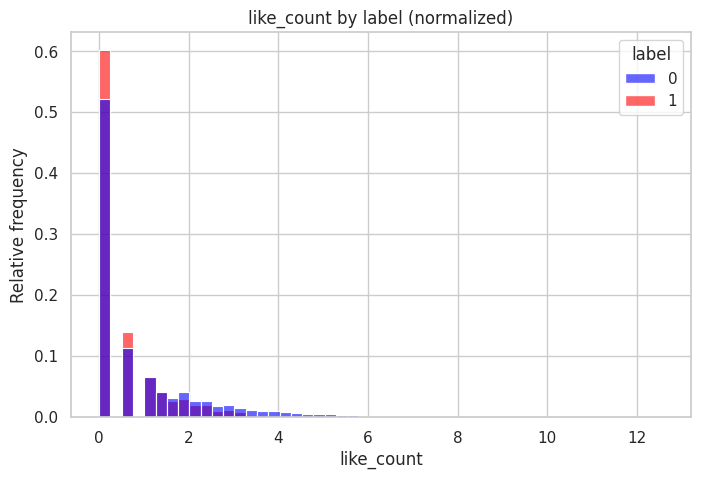

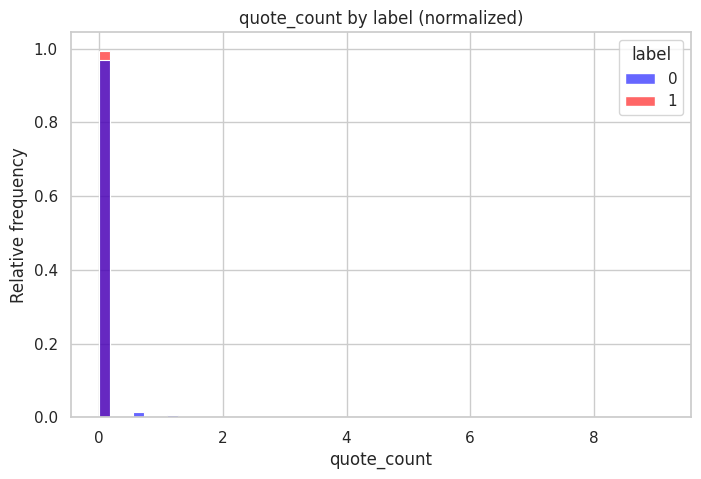

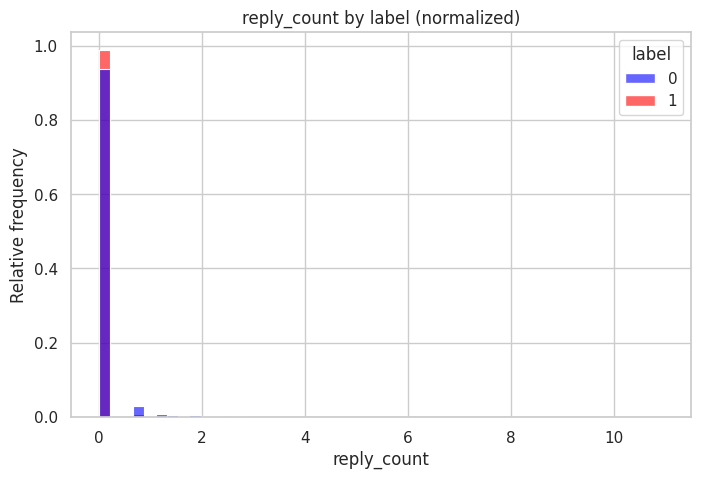

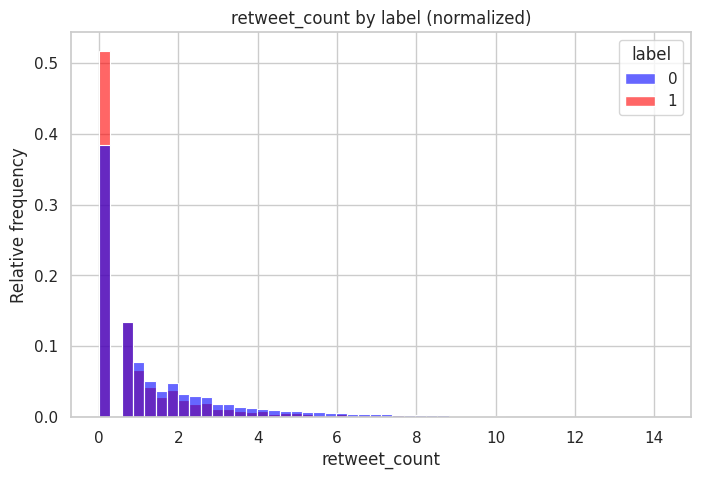

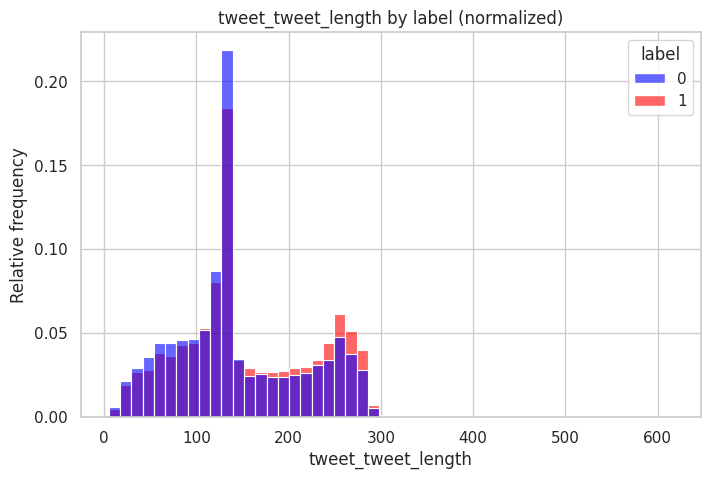

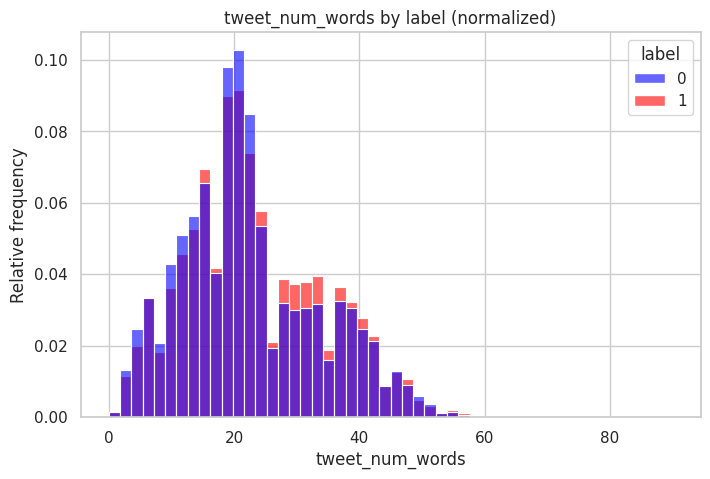

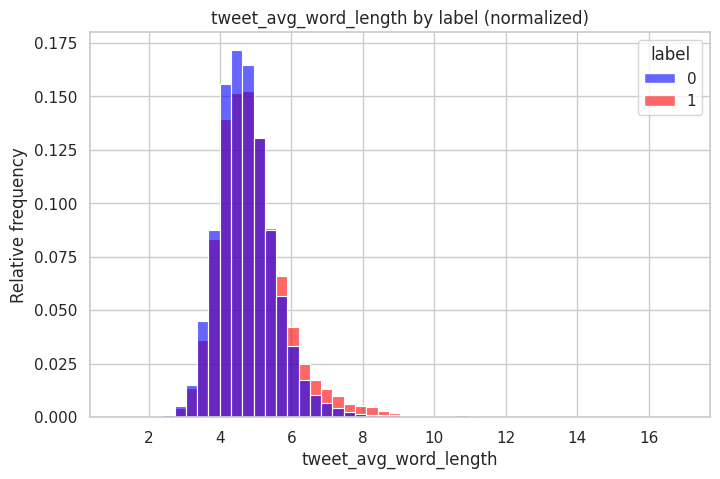

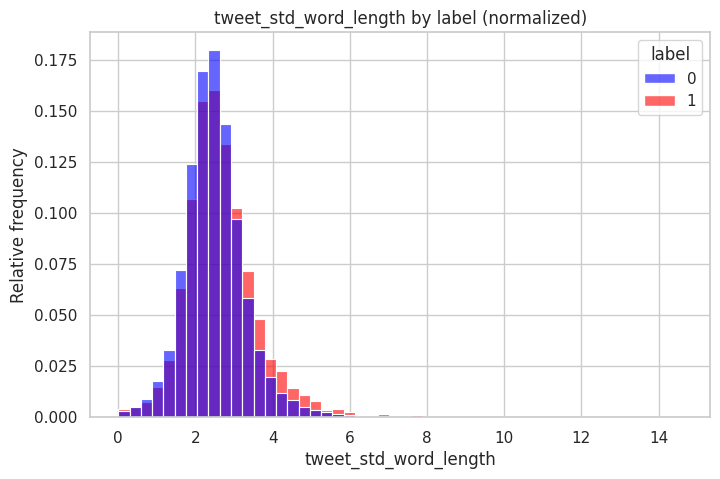

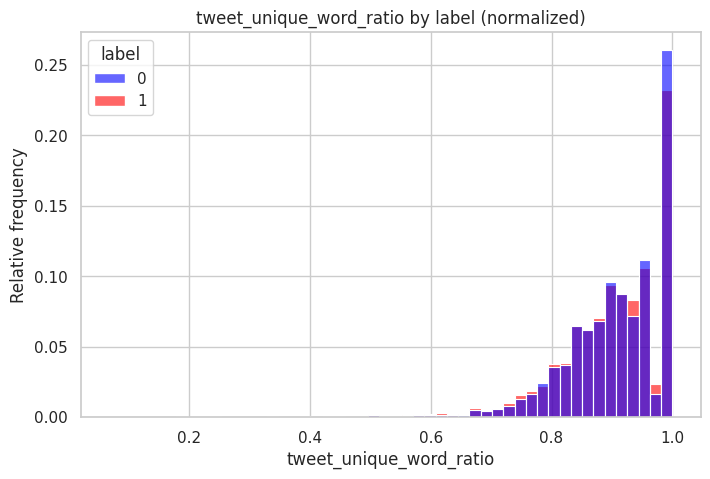

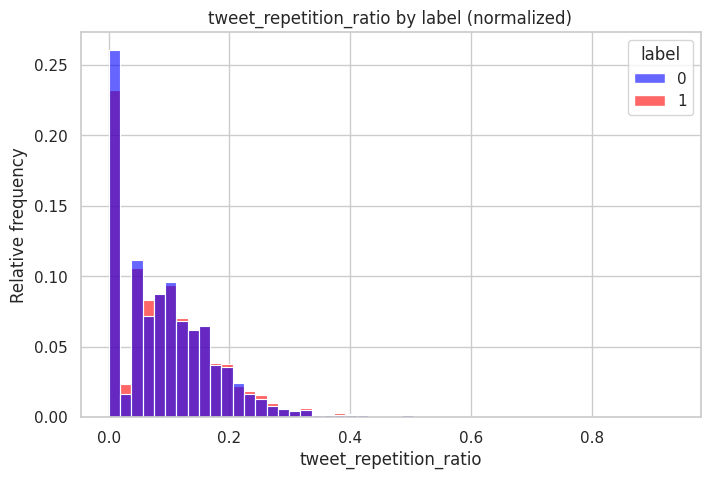

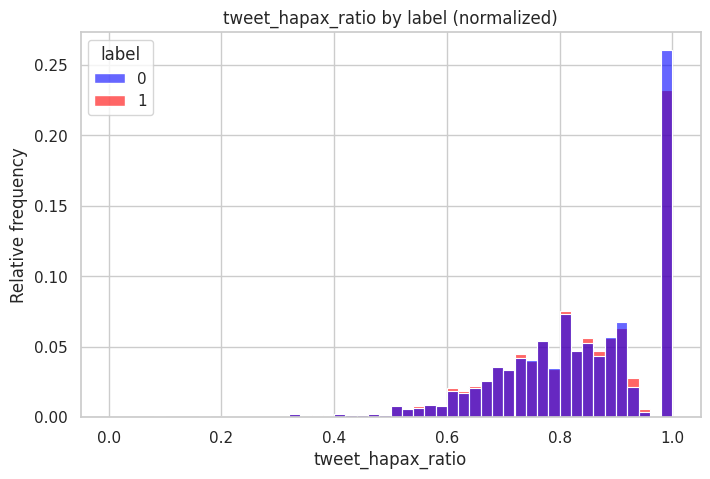

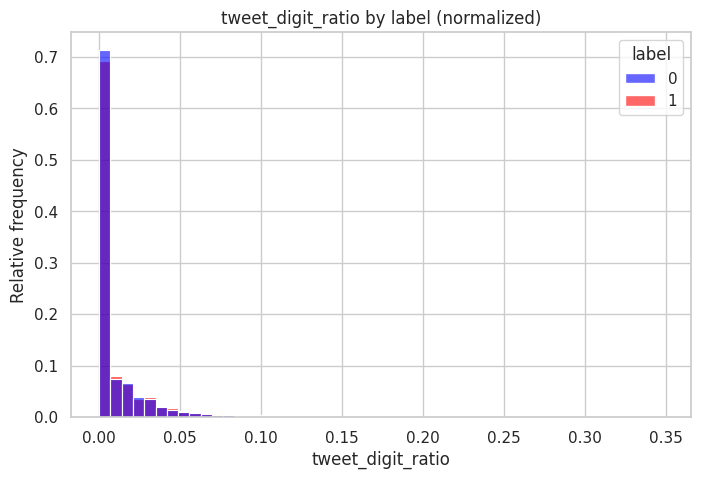

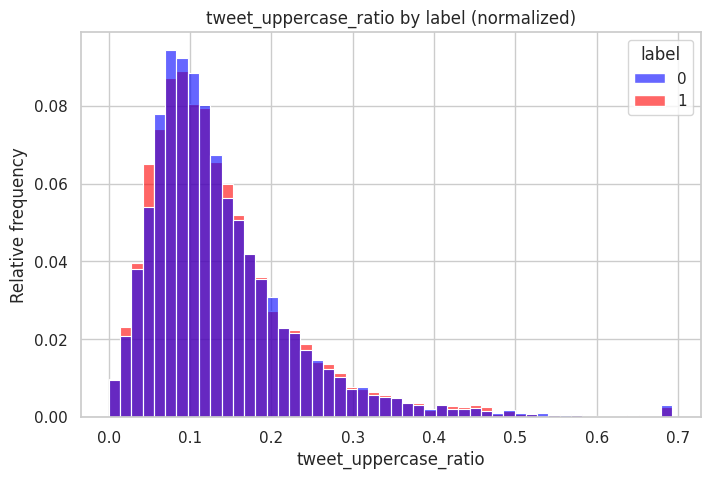

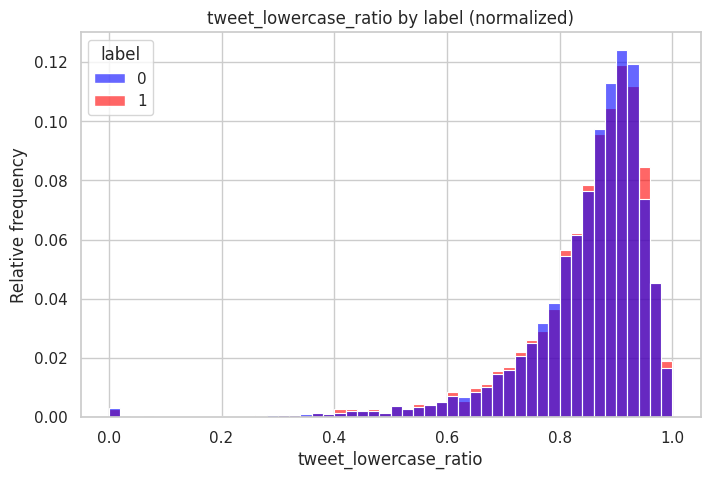

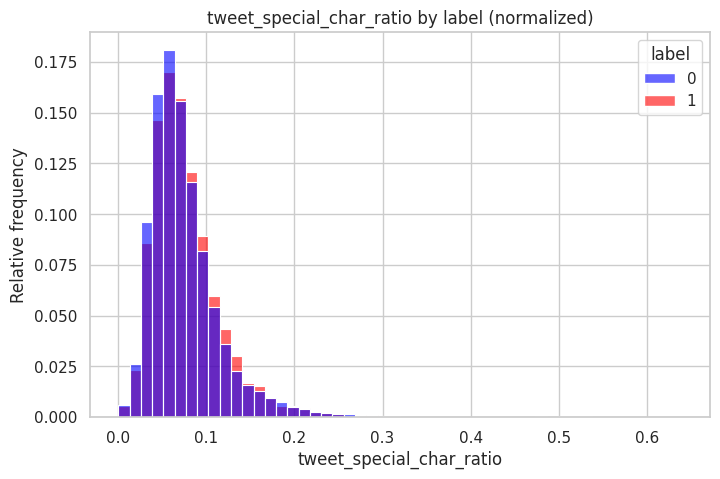

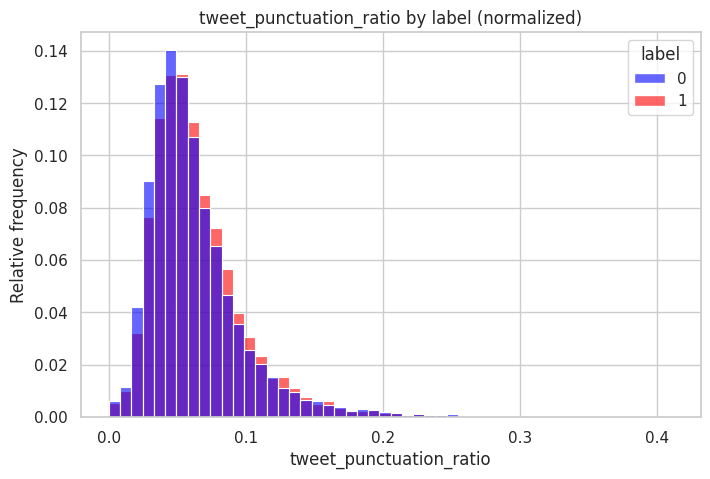

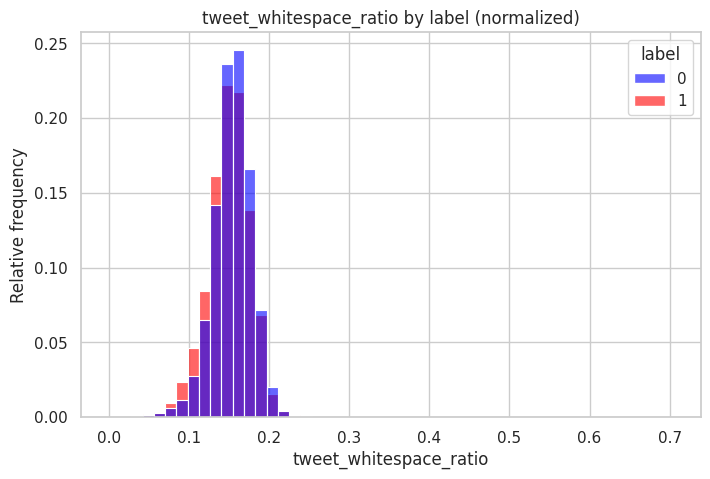

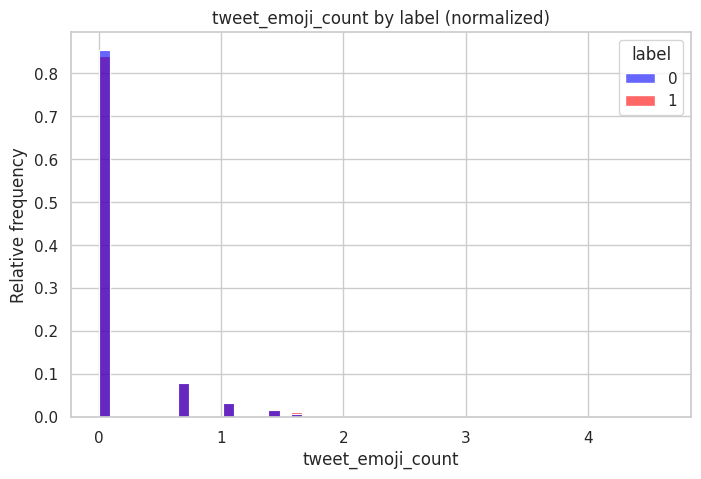

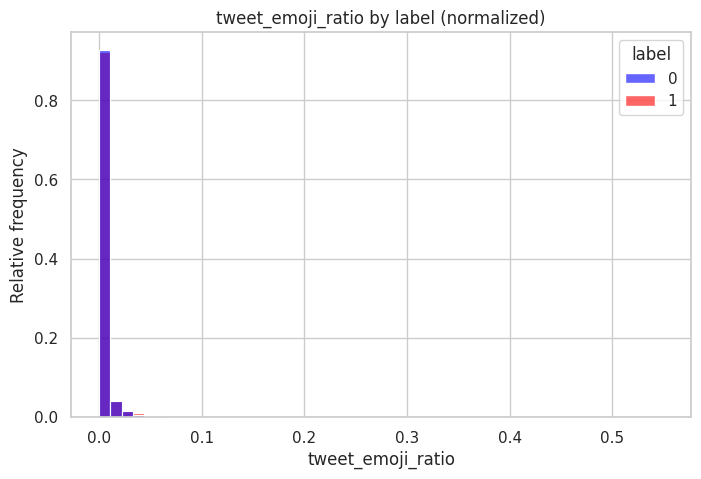

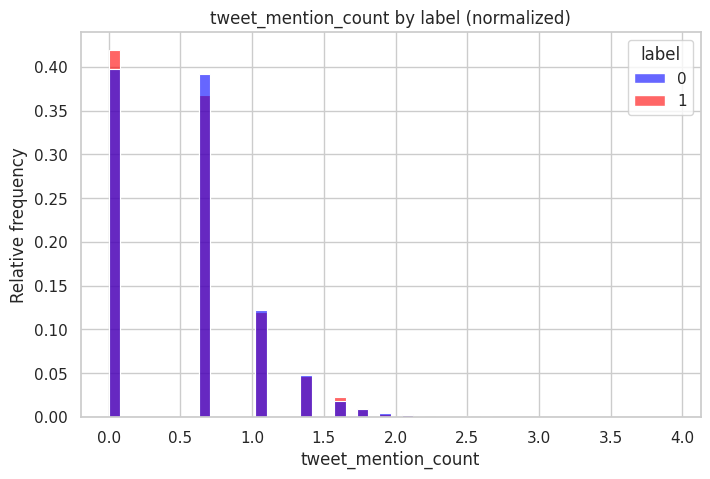

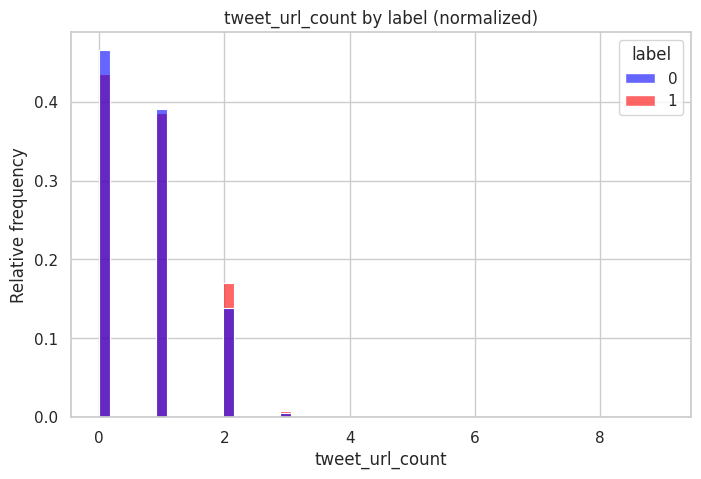

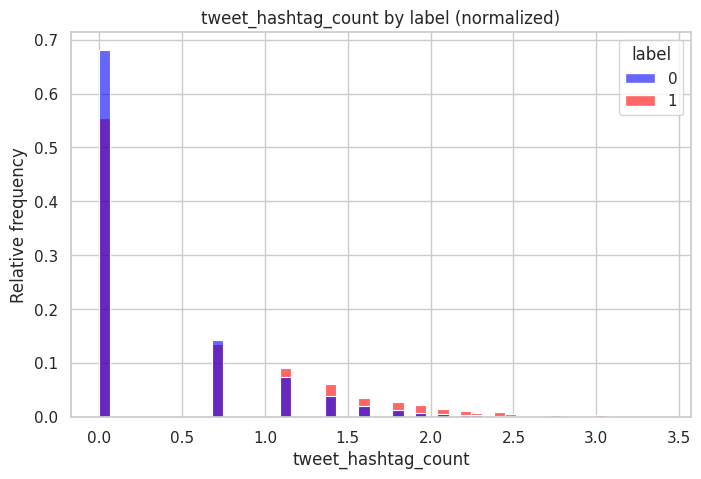

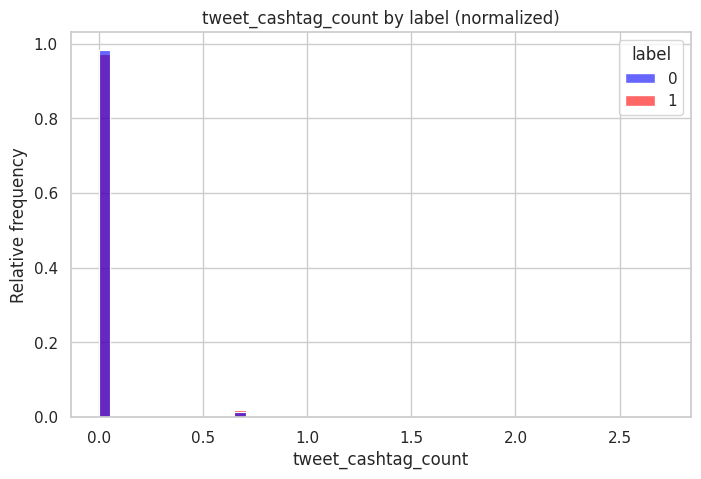

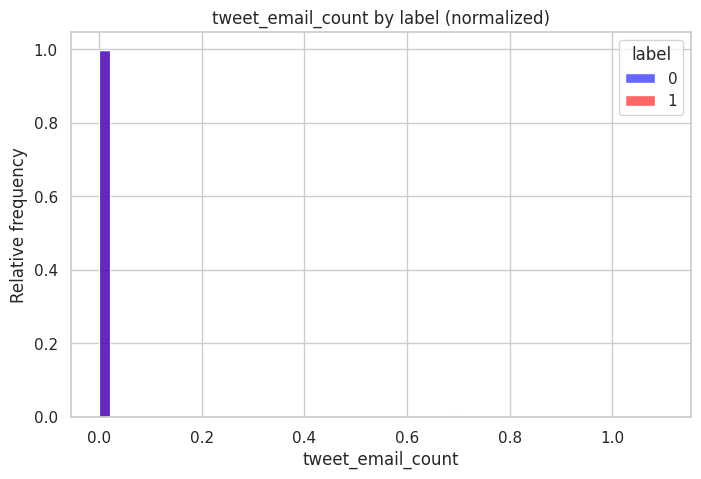

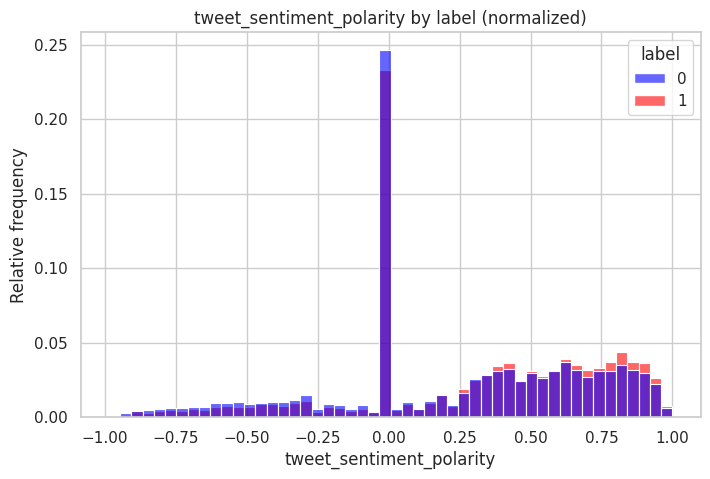

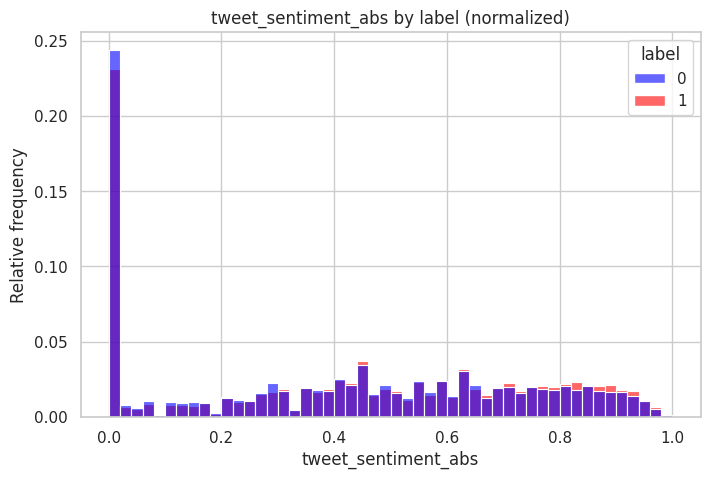

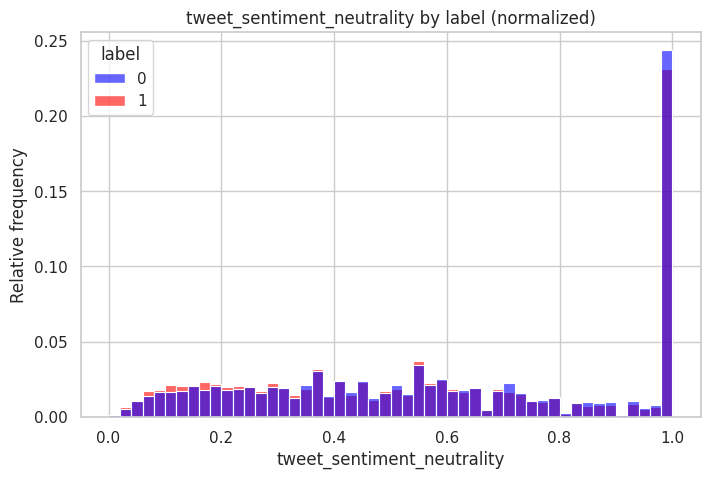

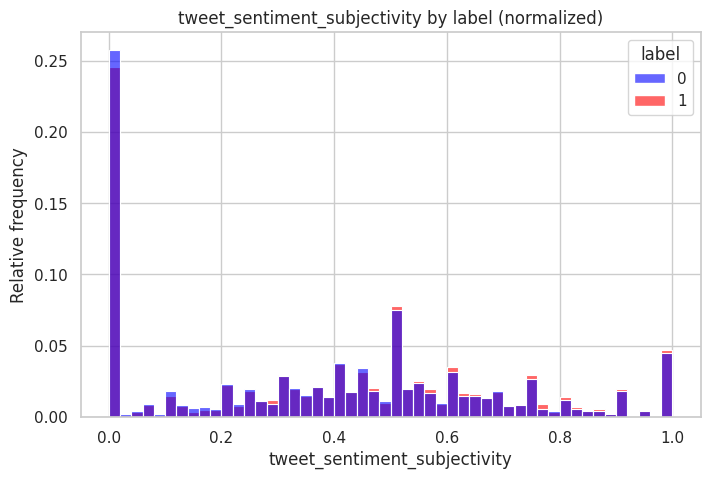

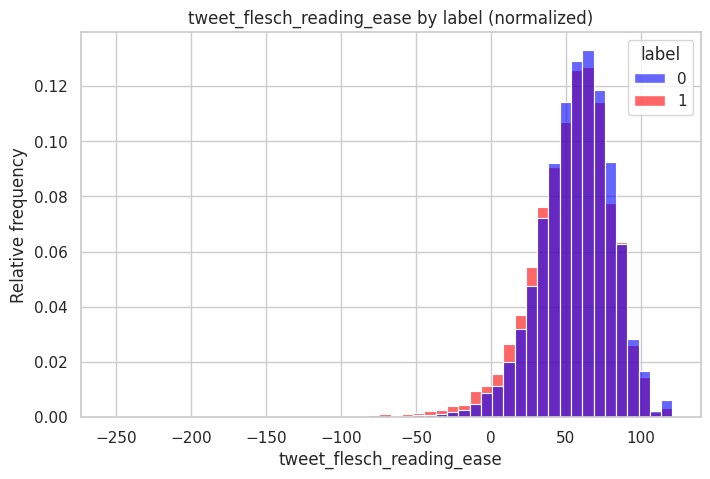

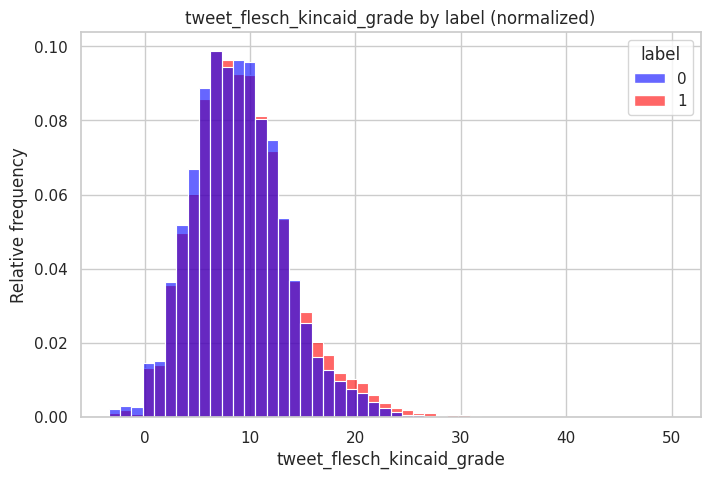

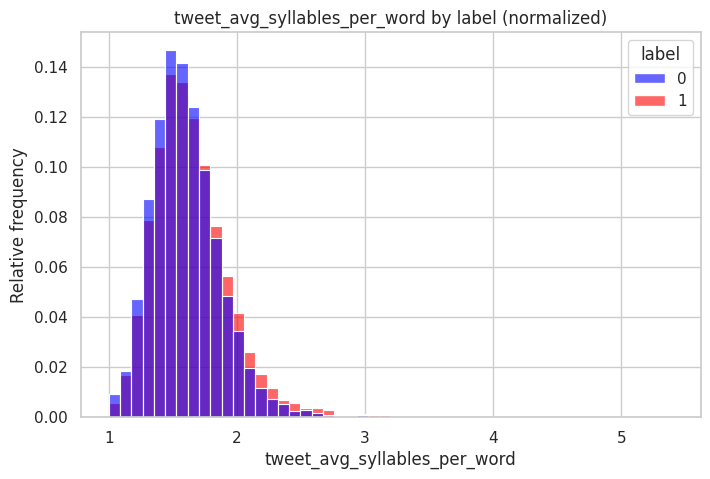

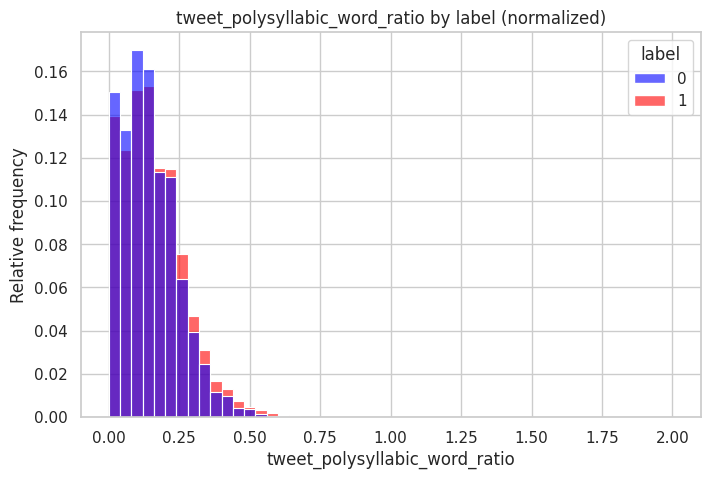

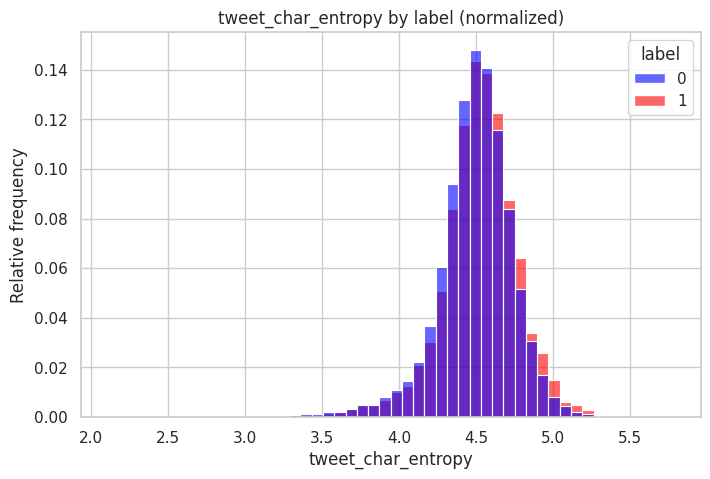

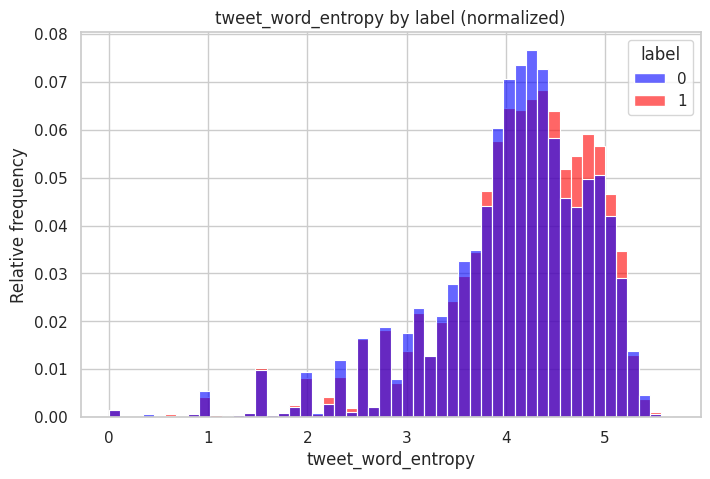

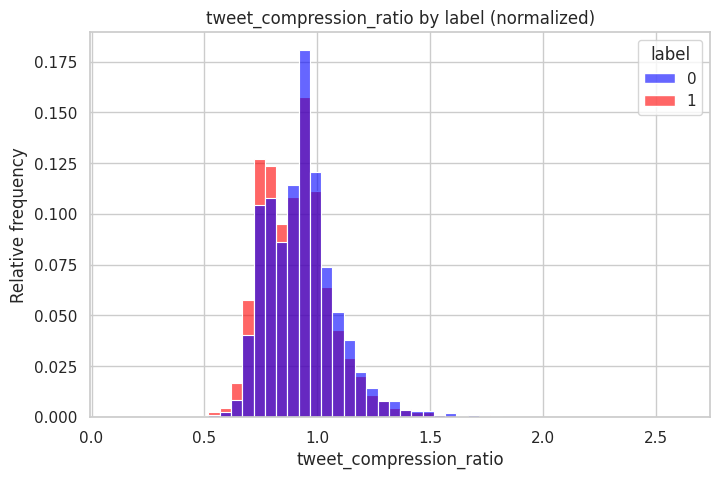

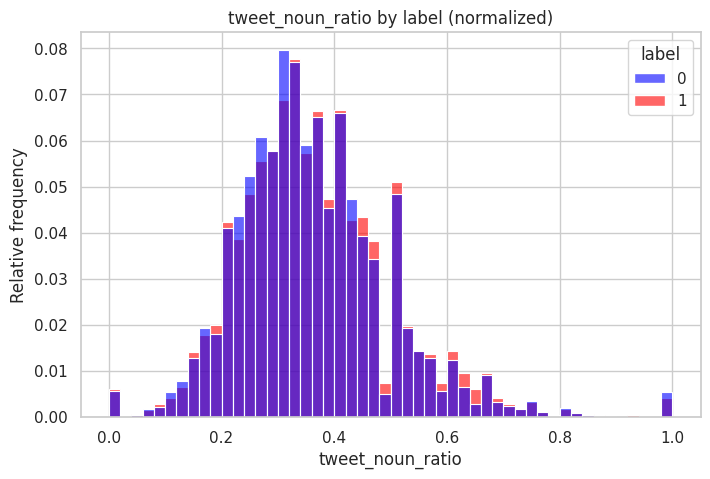

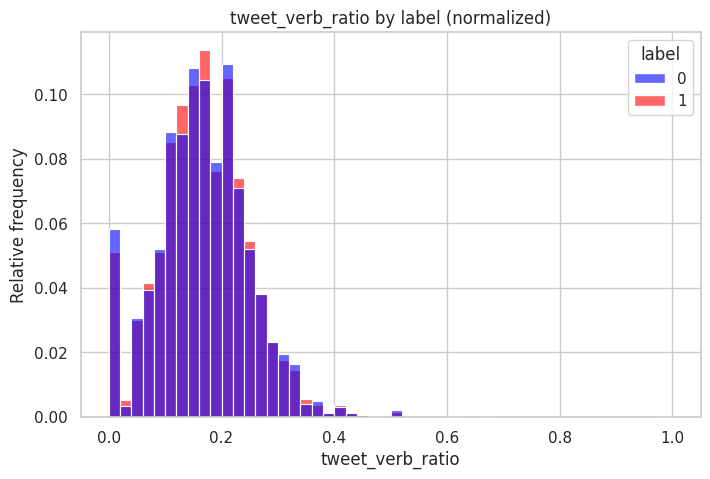

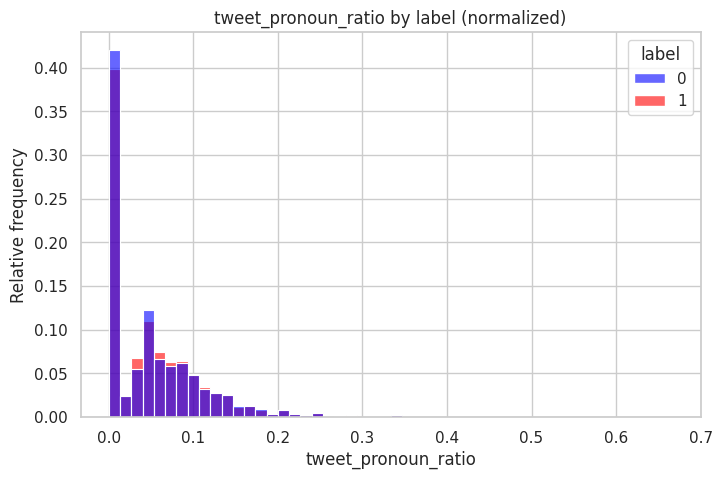

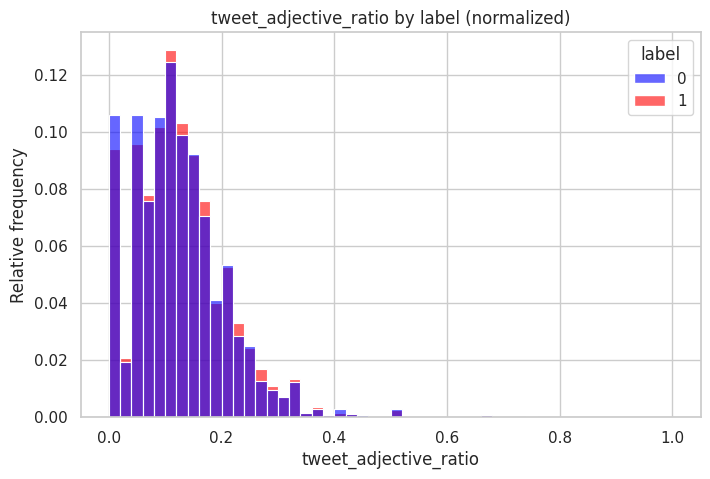

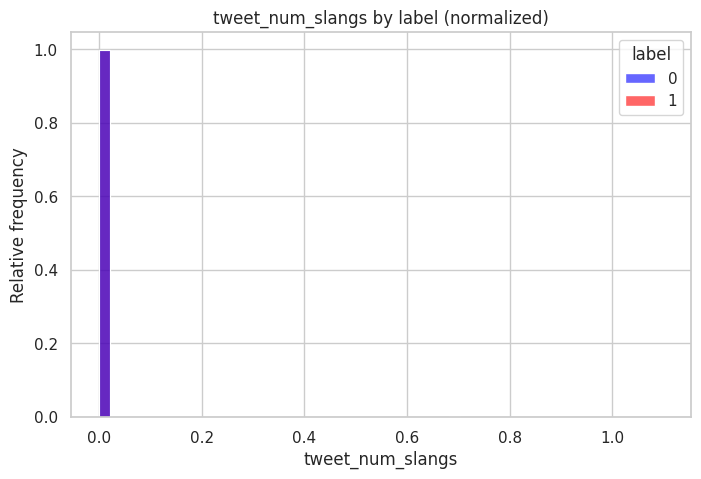

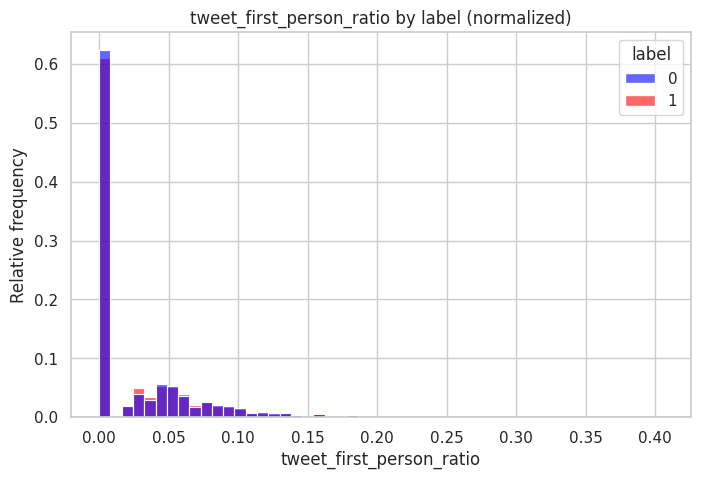

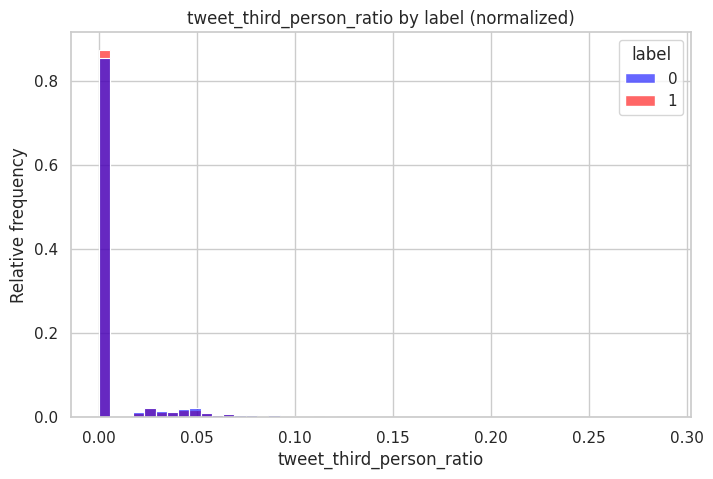

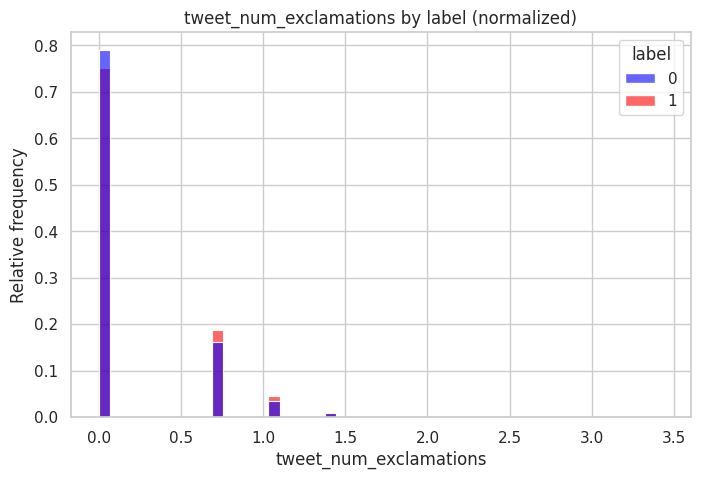

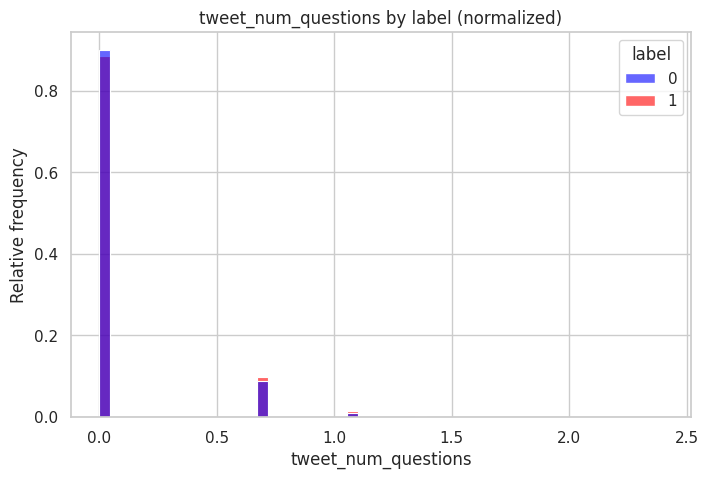

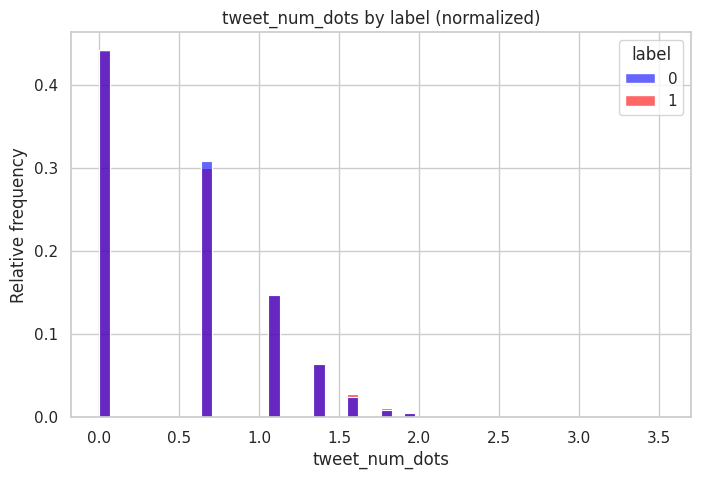

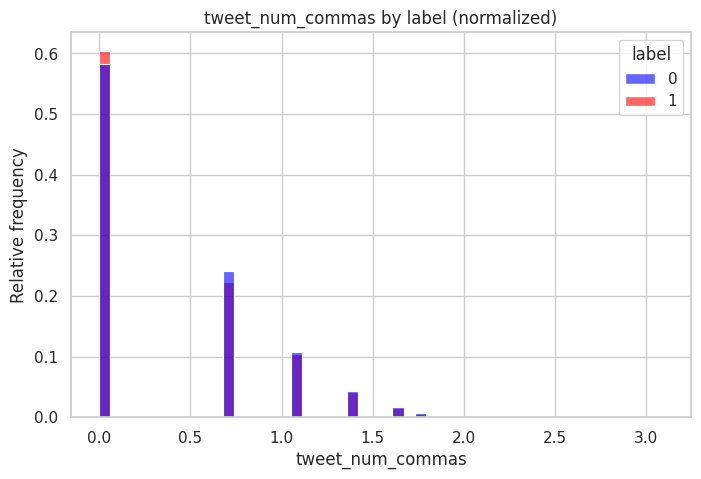

In [34]:
numeric_cols = [col for col in tweet_features_sample_full.select_dtypes(include=np.number).columns if col != "label"]

for col in numeric_cols:
  df_plot = tweet_features_sample_full[[col, 'label']].dropna(subset=[col])
  plot_numeric(df_plot, col)